ほんまか？と思ったポイント
- activationはLeakyReLU (勾配消失しやすいのかな...？）
- 出力層はtanhで(-1, 1)に収めていくスタイル (はっきりとした画像になるらしい、ほんまか....？)


In [1]:
import random
import warnings
warnings.resetwarnings()
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_addons as tfa
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import ReLU
from keras.models import Sequential
from keras import metrics
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU

In [2]:
img_shape = (28, 28, 1)

In [3]:
def build_generator(img_shape, z_dim, hidden_layers_activation, output_layer_activation):
    # z_dim: 入力ノイズの次元
    if hidden_layers_activation == 'relu':
        activation = ReLU()
    elif hidden_layers_activation == 'leaky_relu':
        activation =  LeakyReLU(alpha=0.01)
    else:
        raise ValueError()
        
    model = Sequential([
        Dense(128, input_dim=z_dim),
        activation, 
        Dense(np.prod(img_shape), activation=output_layer_activation),
        Reshape(img_shape)
    ])
    
    return model

In [4]:
def build_discriminator(img_shape, hidden_layers_activation):
    
    if hidden_layers_activation == 'relu':
        activation = ReLU()
    elif hidden_layers_activation == 'leaky_relu':
        activation = LeakyReLU(alpha=0.01)
    else:
        raise ValueError()
        
    model = Sequential([
        Flatten(input_shape=img_shape),
        Dense(128),
        activation, 
        Dense(1, activation='sigmoid'),
    ])
    
    return model

In [5]:
def build_gan(generator, descriminator):
    
    model = Sequential([
        generator,
        descriminator
    ])
    
    return model

In [6]:
def build_model(hidden_layers_activation, output_layer_activation):

        
    discriminator = build_discriminator(img_shape, hidden_layers_activation)   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    generator = build_generator(img_shape, 100, hidden_layers_activation, output_layer_activation)
    discriminator.trainble = False
    
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    return discriminator,  generator, gan

In [7]:
def train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    # Load the MNIST dataset
    (train_x, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    if output_layer_activation == 'sigmoid':
        scaling = [0, 1]
    elif output_layer_activation == 'tanh':
        scaling = [-1, 1]
    else:
        raise ValueError()
    
    
    train_x = train_x / (255 / (scaling[1] - scaling[0])) + scaling[0]
    print('train_x is scaled', np.min(train_x), '~', np.max(train_x))
    train_x = np.expand_dims(train_x, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, train_x.shape[0], batch_size)
        imgs = train_x[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator, 4, 4, 100, scaling)
    losses = np.array(losses)

    # Plot training losses for Discriminator and Generator
    plt.figure(figsize=(15, 5))
    plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
    plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

    plt.xticks(iteration_checkpoints, rotation=90)

    plt.title("Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
    accuracies = np.array(accuracies)

    # Plot Discriminator accuracy
    plt.figure(figsize=(15, 5))
    plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

    plt.xticks(iteration_checkpoints, rotation=90)
    plt.yticks(range(0, 100, 5))

    plt.title("Discriminator Accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

In [8]:
def sample_images(generator, row, col, z_dim, scaled):
    z = np.random.normal(0, 1, (row * col, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = (1 / (scaled[1] - scaled[0])) * gen_imgs + 0.5
    
    fig, axis = plt.subplots(row, col, figsize=(4, 4), sharey=True, sharex=True)
    
    count = 0
    for i in range(row):
        for j in range(col):
            axis[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axis[i, j].axis('off')
            count += 1
            
    plt.show()

In [9]:
def learning_curve():
    global losses, iteration_checkpoints, accuracies
    losses = np.array(losses)

    # Plot training losses for Discriminator and Generator
    plt.figure(figsize=(15, 5))
    plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
    plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

    plt.xticks(iteration_checkpoints, rotation=90)

    plt.title("Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
    accuracies = np.array(accuracies)

    # Plot Discriminator accuracy
    plt.figure(figsize=(15, 5))
    plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

    plt.xticks(iteration_checkpoints, rotation=90)
    plt.yticks(range(0, 100, 5))

    plt.title("Discriminator Accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

train_x is scaled 0.0 ~ 1.0
1000 [D loss: 0.072685, acc.: 98.83%] [G loss: 4.109279]


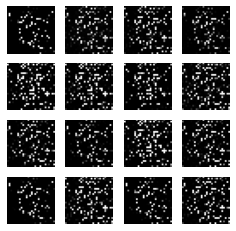

2000 [D loss: 0.067964, acc.: 98.44%] [G loss: 7.508379]


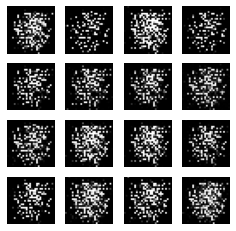

3000 [D loss: 0.095210, acc.: 100.00%] [G loss: 3.014111]


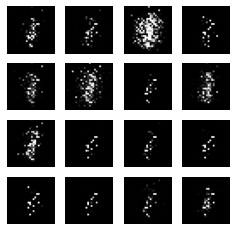

4000 [D loss: 0.080088, acc.: 98.83%] [G loss: 3.496555]


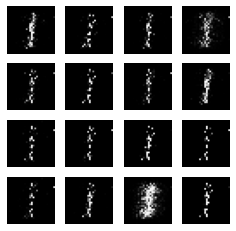

5000 [D loss: 0.054968, acc.: 100.00%] [G loss: 3.416626]


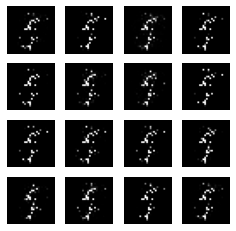

6000 [D loss: 0.031203, acc.: 100.00%] [G loss: 3.377846]


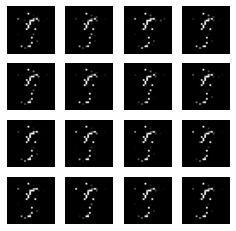

7000 [D loss: 0.017805, acc.: 100.00%] [G loss: 3.871458]


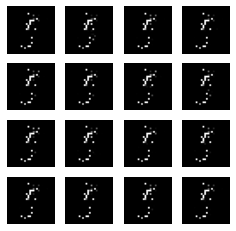

8000 [D loss: 0.011140, acc.: 100.00%] [G loss: 4.191052]


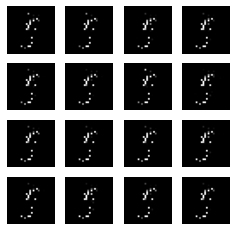

9000 [D loss: 0.007621, acc.: 100.00%] [G loss: 4.679155]


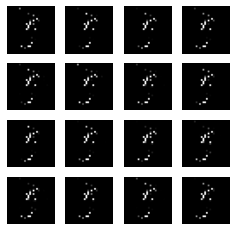

10000 [D loss: 0.004158, acc.: 100.00%] [G loss: 5.304077]


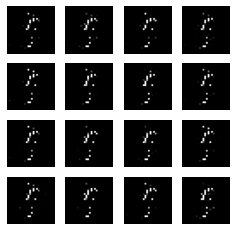

11000 [D loss: 0.002362, acc.: 100.00%] [G loss: 5.658591]


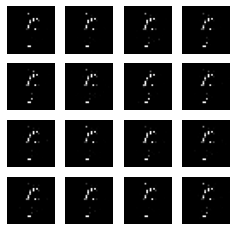

12000 [D loss: 0.001397, acc.: 100.00%] [G loss: 6.337804]


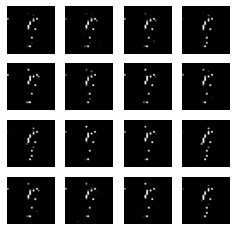

13000 [D loss: 0.000906, acc.: 100.00%] [G loss: 6.602122]


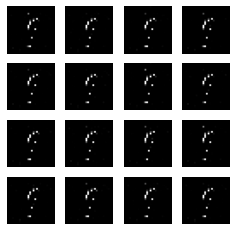

14000 [D loss: 0.000504, acc.: 100.00%] [G loss: 8.056927]


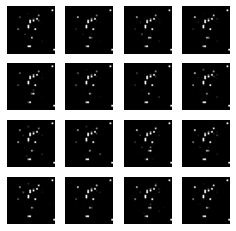

15000 [D loss: 18.146990, acc.: 23.05%] [G loss: 2.345737]


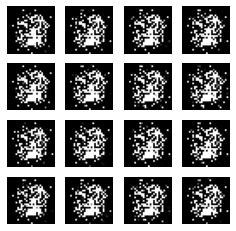

16000 [D loss: 8.741641, acc.: 40.23%] [G loss: 1.272119]


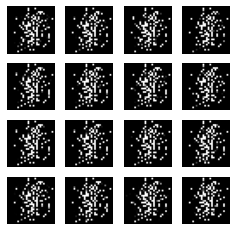

17000 [D loss: 4.189445, acc.: 44.14%] [G loss: 0.899298]


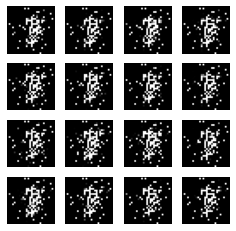

18000 [D loss: 5.438641, acc.: 36.72%] [G loss: 1.170853]


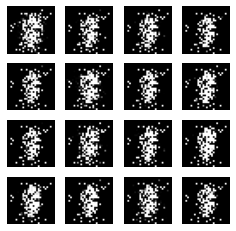

19000 [D loss: 12.305299, acc.: 21.88%] [G loss: 0.933403]


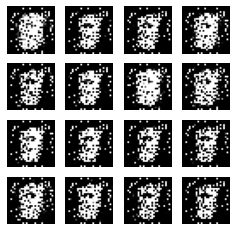

20000 [D loss: 9.990992, acc.: 33.20%] [G loss: 0.748236]


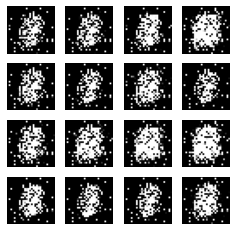

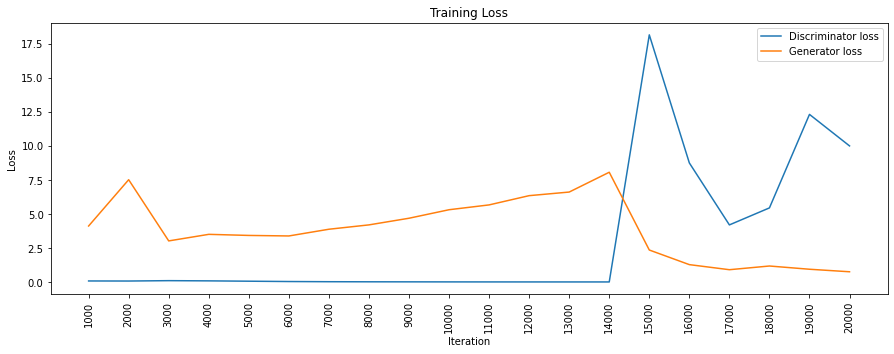

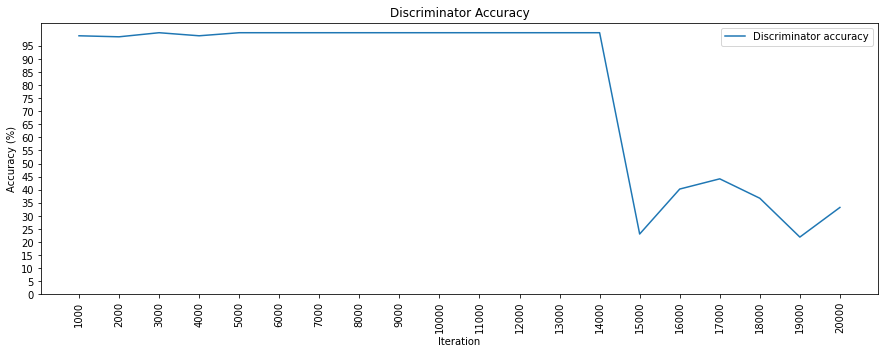

In [10]:
iterations = 20000
batch_size = 128
sample_interval = 1000
output_layer_activation = 'sigmoid'
discriminator,  generator, gan = build_model('relu', output_layer_activation )
train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation)

train_x is scaled -1.0 ~ 1.0
1000 [D loss: 0.106467, acc.: 100.00%] [G loss: 2.005676]


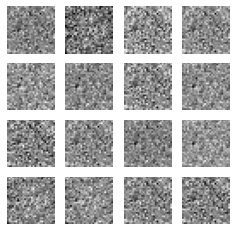

2000 [D loss: 0.058659, acc.: 100.00%] [G loss: 2.772828]


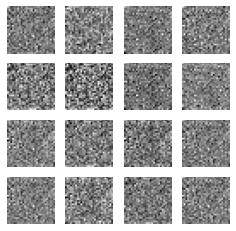

3000 [D loss: 0.040939, acc.: 100.00%] [G loss: 3.185527]


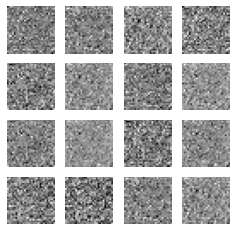

4000 [D loss: 0.029173, acc.: 100.00%] [G loss: 3.465496]


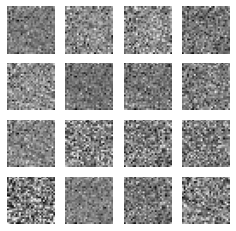

5000 [D loss: 0.017876, acc.: 100.00%] [G loss: 3.569360]


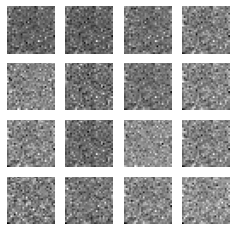

6000 [D loss: 0.011096, acc.: 100.00%] [G loss: 4.045382]


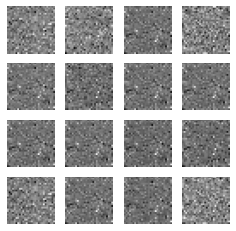

7000 [D loss: 0.006914, acc.: 100.00%] [G loss: 4.402338]


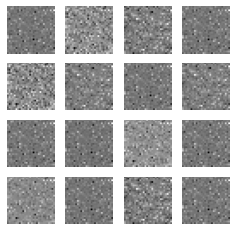

8000 [D loss: 0.003856, acc.: 100.00%] [G loss: 4.985502]


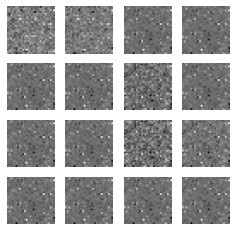

9000 [D loss: 0.002528, acc.: 100.00%] [G loss: 5.443488]


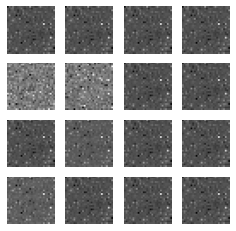

10000 [D loss: 0.001477, acc.: 100.00%] [G loss: 6.111737]


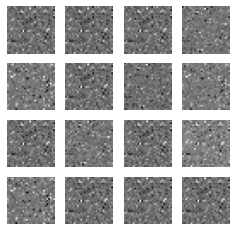

11000 [D loss: 0.000979, acc.: 100.00%] [G loss: 6.506421]


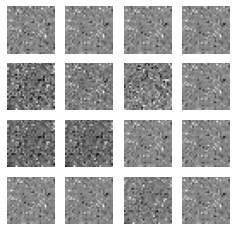

12000 [D loss: 0.157993, acc.: 95.70%] [G loss: 7.605515]


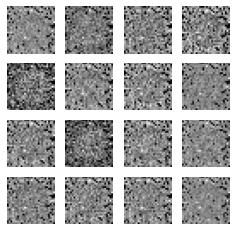

13000 [D loss: 0.204229, acc.: 89.06%] [G loss: 9.049403]


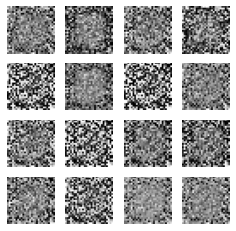

14000 [D loss: 0.049091, acc.: 99.61%] [G loss: 7.323840]


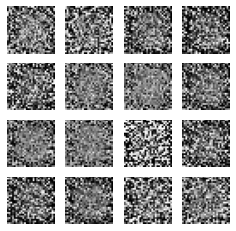

15000 [D loss: 0.077224, acc.: 98.44%] [G loss: 8.712888]


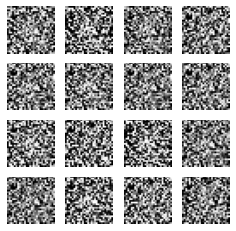

16000 [D loss: 0.041616, acc.: 100.00%] [G loss: 5.589955]


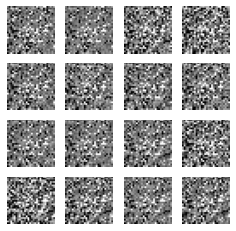

17000 [D loss: 0.023363, acc.: 100.00%] [G loss: 6.430610]


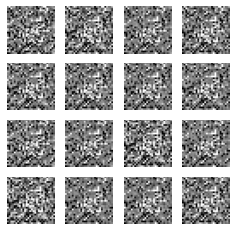

18000 [D loss: 0.015807, acc.: 100.00%] [G loss: 6.549032]


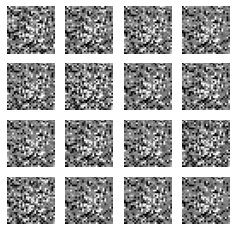

19000 [D loss: 0.337688, acc.: 91.02%] [G loss: 18.702261]


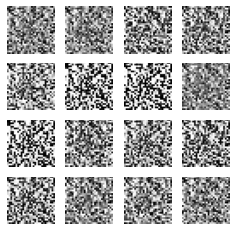

20000 [D loss: 0.044831, acc.: 100.00%] [G loss: 6.000036]


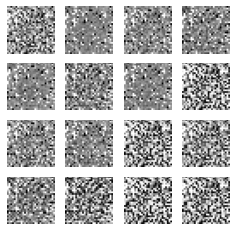

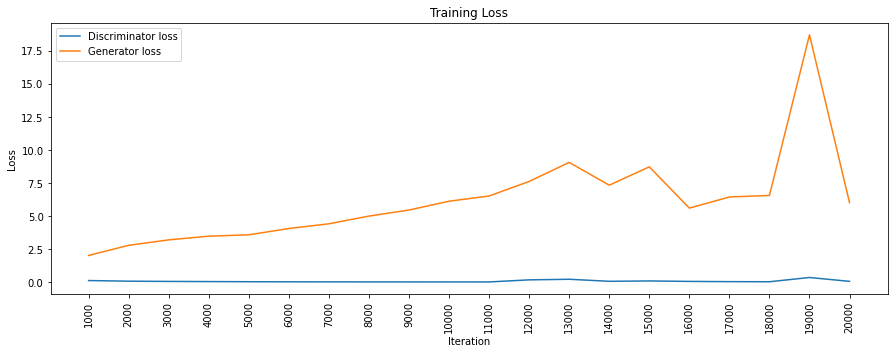

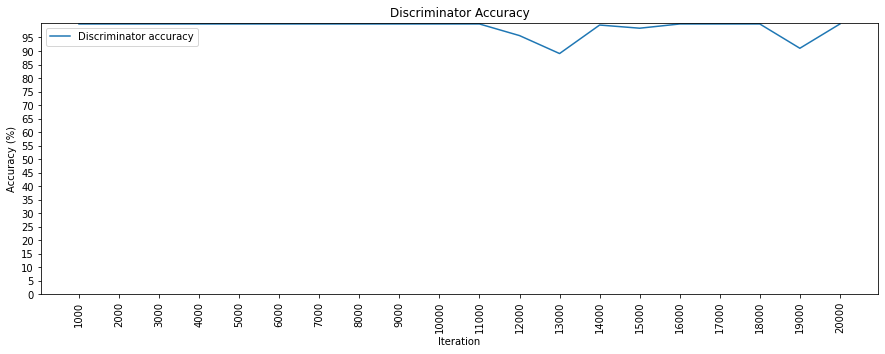

In [11]:
iterations = 20000
batch_size = 128
sample_interval = 1000
output_layer_activation = 'tanh'
discriminator,  generator, gan = build_model('relu', output_layer_activation )
train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation)

train_x is scaled 0.0 ~ 1.0
1000 [D loss: 0.047543, acc.: 100.00%] [G loss: 3.430485]


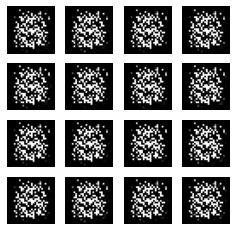

2000 [D loss: 0.105036, acc.: 97.27%] [G loss: 5.609578]


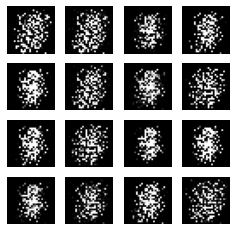

3000 [D loss: 0.114538, acc.: 99.61%] [G loss: 2.659153]


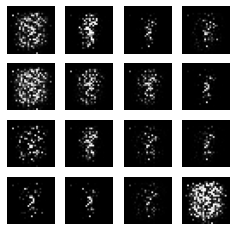

4000 [D loss: 0.160756, acc.: 96.88%] [G loss: 2.224469]


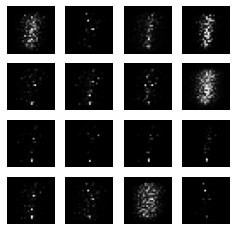

5000 [D loss: 0.147557, acc.: 99.22%] [G loss: 3.127808]


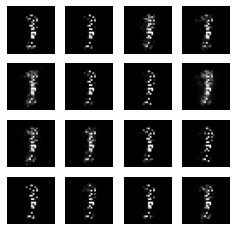

6000 [D loss: 0.339925, acc.: 90.23%] [G loss: 4.316807]


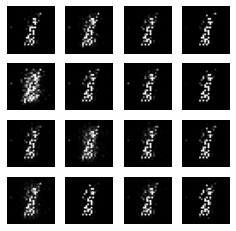

7000 [D loss: 0.162041, acc.: 99.61%] [G loss: 4.315132]


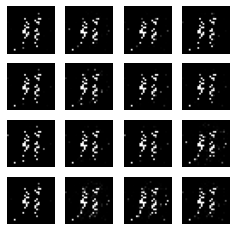

8000 [D loss: 2.253339, acc.: 76.95%] [G loss: 11.153418]


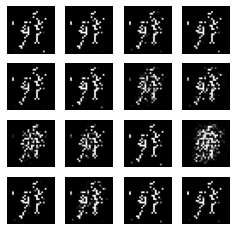

9000 [D loss: 9.354354, acc.: 39.06%] [G loss: 5.654222]


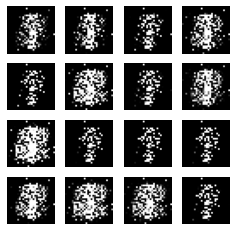

10000 [D loss: 8.754214, acc.: 30.86%] [G loss: 3.790702]


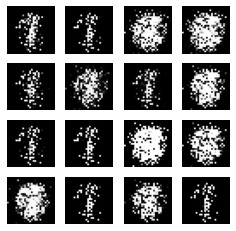

11000 [D loss: 4.786496, acc.: 34.38%] [G loss: 3.792758]


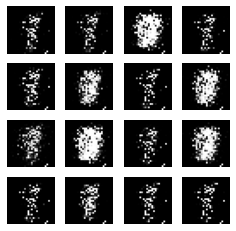

12000 [D loss: 2.974422, acc.: 39.06%] [G loss: 4.896564]


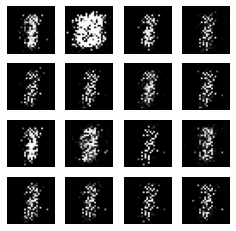

13000 [D loss: 1.994567, acc.: 48.83%] [G loss: 2.546611]


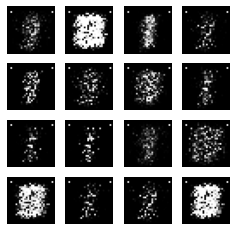

14000 [D loss: 0.959920, acc.: 61.33%] [G loss: 2.061927]


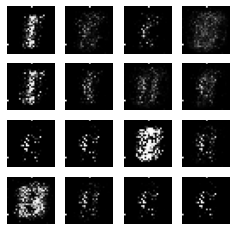

15000 [D loss: 1.116537, acc.: 51.17%] [G loss: 1.786824]


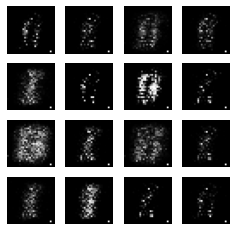

16000 [D loss: 2.576641, acc.: 37.11%] [G loss: 3.065132]


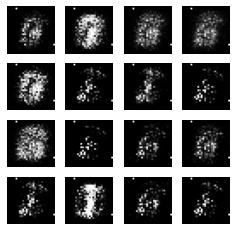

17000 [D loss: 2.014695, acc.: 49.22%] [G loss: 5.805053]


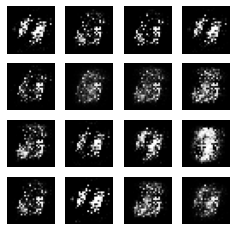

18000 [D loss: 1.448532, acc.: 47.27%] [G loss: 5.568871]


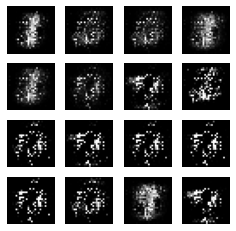

19000 [D loss: 5.333356, acc.: 35.55%] [G loss: 4.346148]


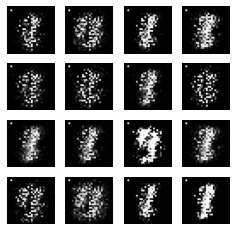

20000 [D loss: 3.781954, acc.: 37.50%] [G loss: 4.183613]


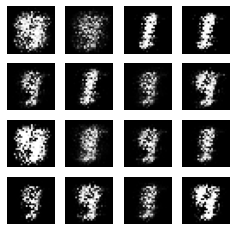

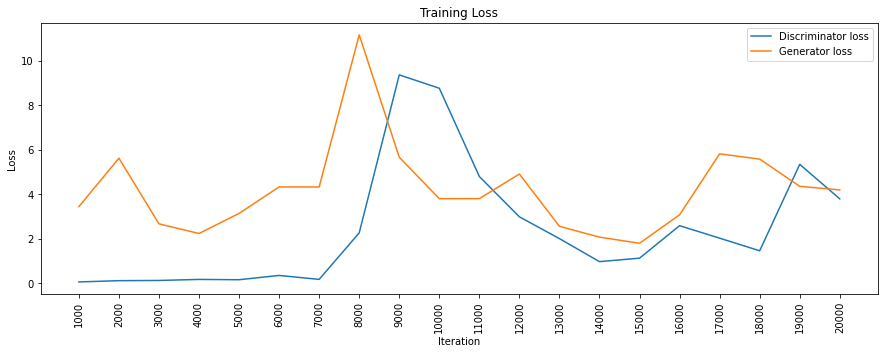

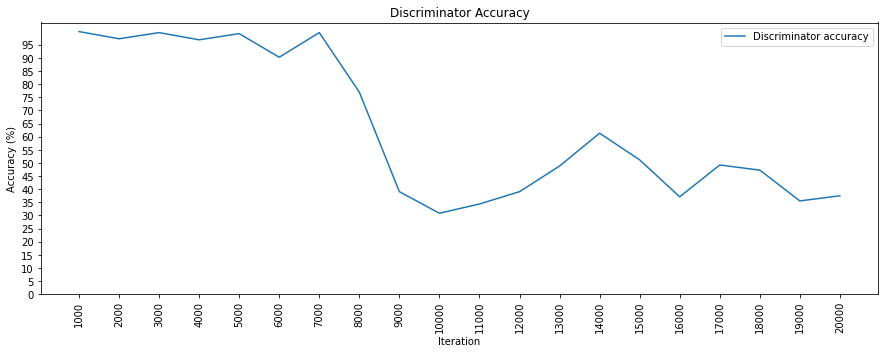

In [12]:
iterations = 20000
batch_size = 128
sample_interval = 1000
output_layer_activation = 'sigmoid'
discriminator,  generator, gan = build_model('leaky_relu', output_layer_activation)
train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation)

train_x is scaled -1.0 ~ 1.0
1000 [D loss: 0.194502, acc.: 96.09%] [G loss: 1.324120]


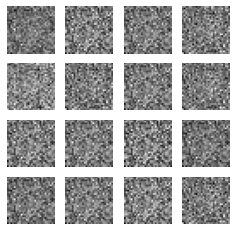

2000 [D loss: 0.147285, acc.: 99.61%] [G loss: 2.251455]


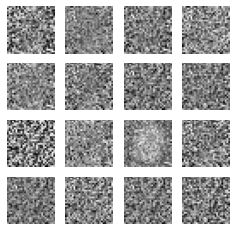

3000 [D loss: 0.102569, acc.: 99.61%] [G loss: 2.556778]


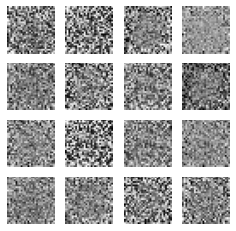

4000 [D loss: 0.081179, acc.: 100.00%] [G loss: 3.503035]


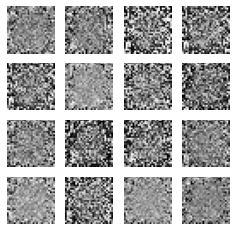

5000 [D loss: 0.052783, acc.: 100.00%] [G loss: 3.830539]


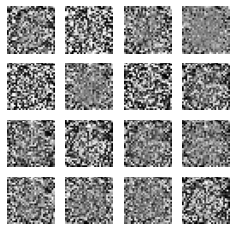

6000 [D loss: 0.034429, acc.: 100.00%] [G loss: 3.806662]


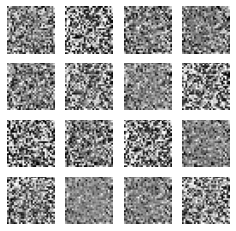

7000 [D loss: 0.021900, acc.: 100.00%] [G loss: 3.554636]


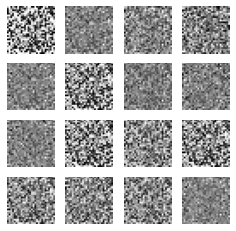

8000 [D loss: 0.018452, acc.: 100.00%] [G loss: 4.926665]


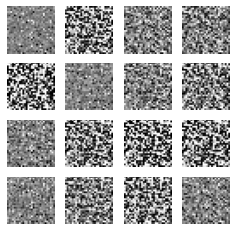

9000 [D loss: 0.013780, acc.: 100.00%] [G loss: 4.212376]


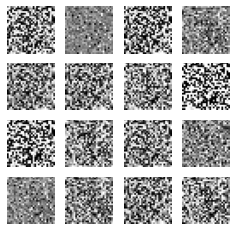

10000 [D loss: 0.007659, acc.: 100.00%] [G loss: 4.731546]


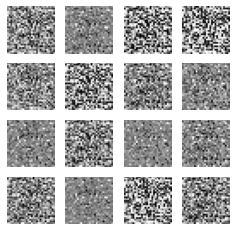

11000 [D loss: 0.004756, acc.: 100.00%] [G loss: 4.815335]


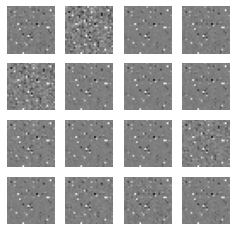

12000 [D loss: 0.002751, acc.: 100.00%] [G loss: 5.433743]


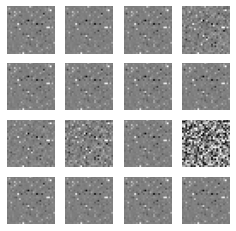

13000 [D loss: 0.001671, acc.: 100.00%] [G loss: 5.852286]


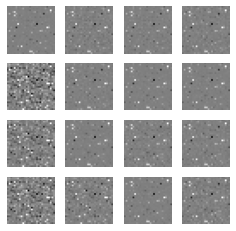

14000 [D loss: 0.000963, acc.: 100.00%] [G loss: 6.486896]


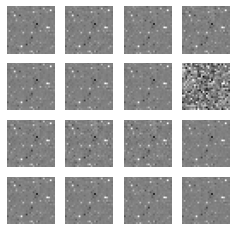

15000 [D loss: 0.000633, acc.: 100.00%] [G loss: 7.295497]


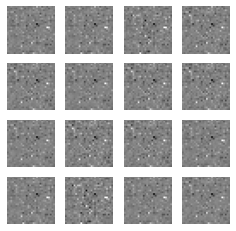

16000 [D loss: 0.361118, acc.: 82.42%] [G loss: 6.293150]


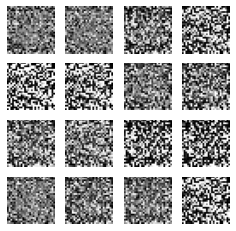

17000 [D loss: 0.167038, acc.: 93.36%] [G loss: 6.535972]


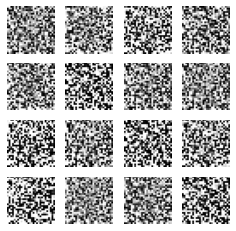

18000 [D loss: 0.091333, acc.: 97.27%] [G loss: 6.943223]


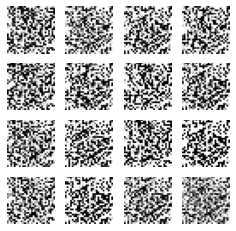

19000 [D loss: 0.060407, acc.: 99.61%] [G loss: 6.909309]


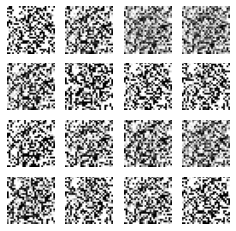

20000 [D loss: 0.030200, acc.: 100.00%] [G loss: 5.707588]


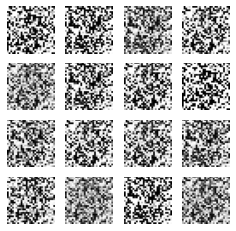

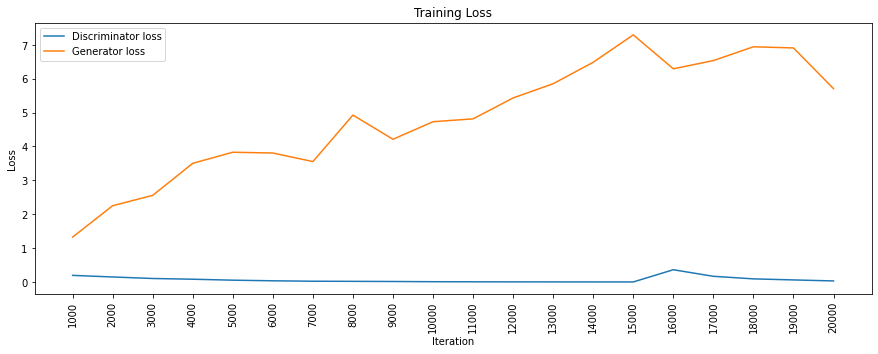

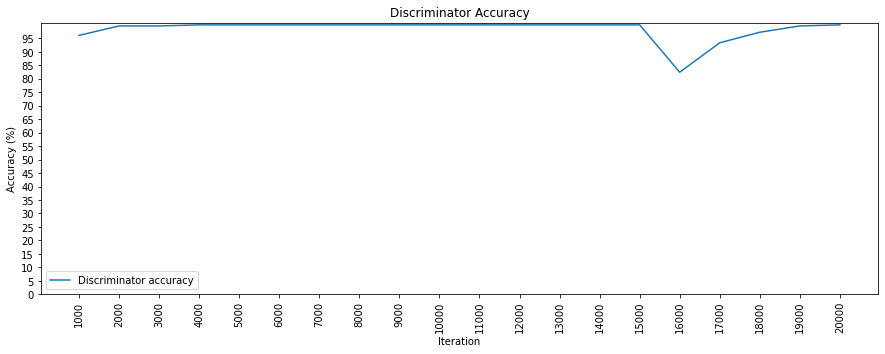

In [13]:
iterations = 20000
batch_size = 128
sample_interval = 1000
output_layer_activation = 'tanh'
discriminator,  generator, gan = build_model('leaky_relu', output_layer_activation)
train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation)

In [14]:
def nice_optimizer_build_model(hidden_layers_activation, output_layer_activation):
    optimizer = tfa.optimizers.Lookahead(
            tfa.optimizers.AdamW(weight_decay=1e-5),
            sync_period=250
        )
        
    discriminator = build_discriminator(img_shape, hidden_layers_activation)   
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer, 
                          metrics=['accuracy'])

    # discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    generator = build_generator(img_shape, 100, hidden_layers_activation, output_layer_activation)
    discriminator.trainble = False
    
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy',
                          optimizer=optimizer)
    # gan.compile(loss='binary_crossentropy', optimizer=Adam())
    return discriminator,  generator, gan

train_x is scaled -1.0 ~ 1.0
1000 [D loss: 0.367350, acc.: 60.16%] [G loss: 0.664453]


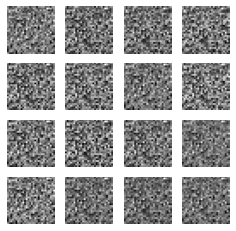

2000 [D loss: 0.356515, acc.: 63.28%] [G loss: 0.693946]


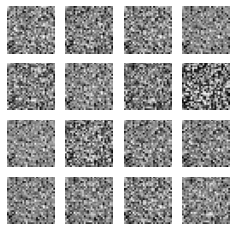

3000 [D loss: 0.586171, acc.: 54.69%] [G loss: 0.589713]


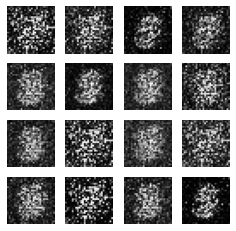

4000 [D loss: 0.657389, acc.: 50.78%] [G loss: 0.544385]


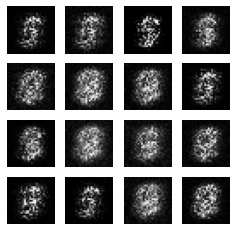

5000 [D loss: 0.591027, acc.: 50.00%] [G loss: 0.563758]


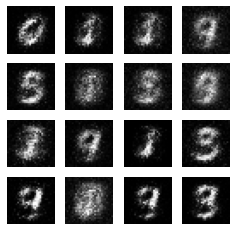

6000 [D loss: 0.623283, acc.: 50.00%] [G loss: 0.558696]


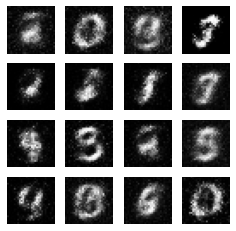

7000 [D loss: 0.662627, acc.: 50.00%] [G loss: 0.493224]


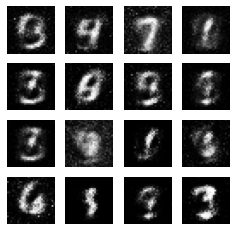

8000 [D loss: 0.754945, acc.: 49.22%] [G loss: 0.446652]


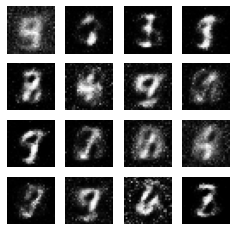

9000 [D loss: 0.702092, acc.: 50.00%] [G loss: 0.498296]


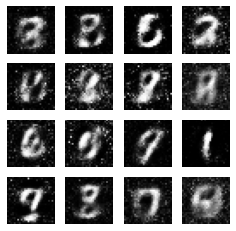

10000 [D loss: 0.594006, acc.: 55.47%] [G loss: 0.569477]


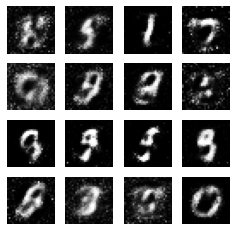

11000 [D loss: 0.671671, acc.: 51.95%] [G loss: 0.483763]


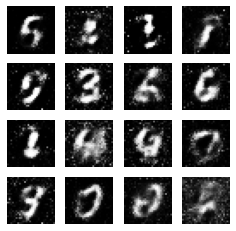

12000 [D loss: 0.624042, acc.: 52.73%] [G loss: 0.546616]


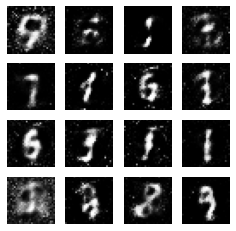

13000 [D loss: 0.629639, acc.: 51.56%] [G loss: 0.529795]


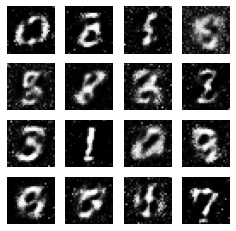

14000 [D loss: 0.755219, acc.: 50.00%] [G loss: 0.431405]


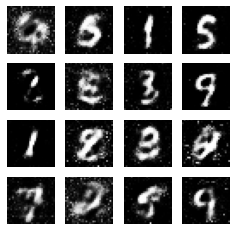

15000 [D loss: 0.703073, acc.: 50.78%] [G loss: 0.458117]


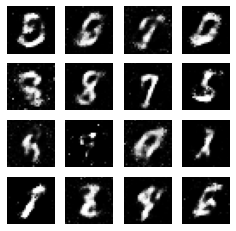

16000 [D loss: 0.704608, acc.: 50.00%] [G loss: 0.459890]


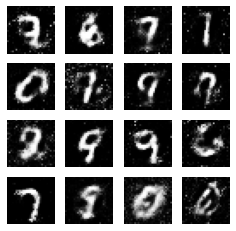

17000 [D loss: 0.632272, acc.: 55.08%] [G loss: 0.517413]


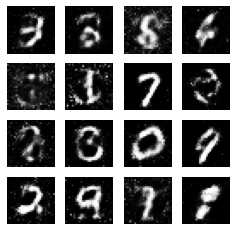

18000 [D loss: 0.687559, acc.: 50.78%] [G loss: 0.477766]


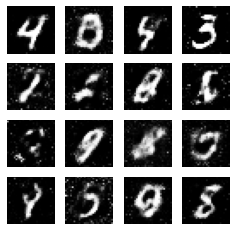

19000 [D loss: 0.679287, acc.: 51.95%] [G loss: 0.477134]


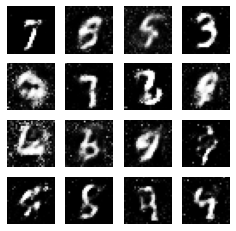

20000 [D loss: 0.605004, acc.: 58.59%] [G loss: 0.529217]


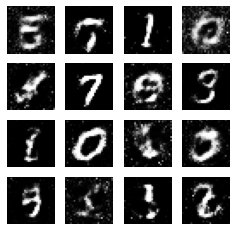

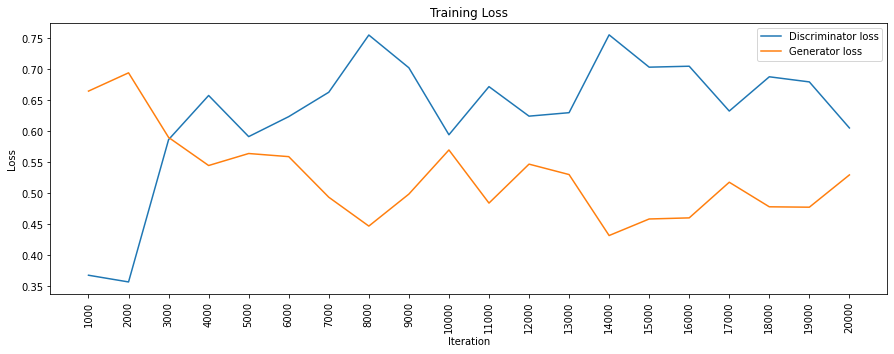

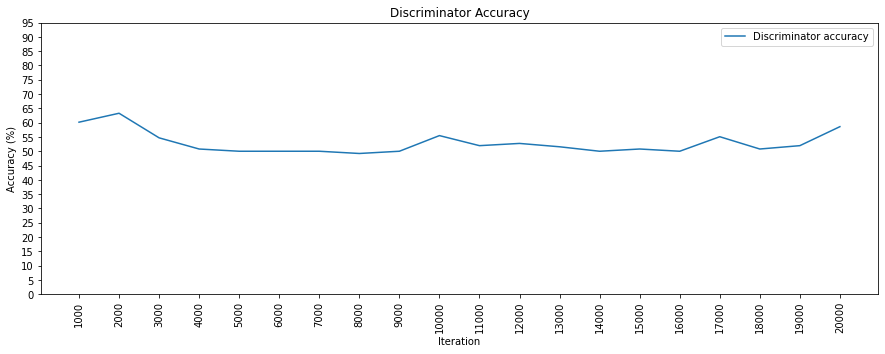

In [15]:
iterations = 20000
batch_size = 128
sample_interval = 1000
output_layer_activation = 'tanh'
discriminator,  generator, gan = nice_optimizer_build_model('leaky_relu', output_layer_activation )
train(discriminator, generator, gan, iterations, batch_size, sample_interval, output_layer_activation)